# Example 6: Solving Partial Differential Equation (PDE)

We aim to solve a 2D poisson equation $\nabla^2 f(x,y) = -2\pi^2{\rm sin}(\pi x){\rm sin}(\pi y)$, with boundary condition $f(-1,y)=f(1,y)=f(x,-1)=f(x,1)=0$. The ground truth solution is $f(x,y)={\rm sin}(\pi x){\rm sin}(\pi y)$.

pde loss: 4.01e-03 | bc loss: 9.16e-08 | l2: 1.82e-07 | mse: 1.82e-07 : 100%|██████████| 1000/1000 [00:27<00:00, 36.65it/s]


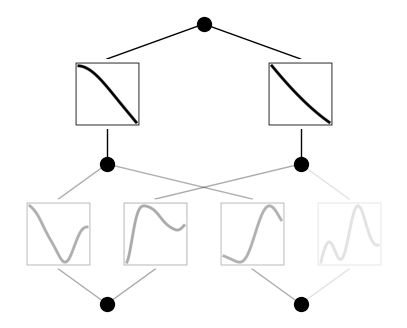

In [1]:
from fast_kan import KAN, LBFGS
import torch
import matplotlib.pyplot as plt
from torch import autograd
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print (device)
# Domain and dimensions
torch.manual_seed(5)
dim = 2
np_i = 51  # Number of interior points along each dimension
np_b = 51  # Number of boundary points along each dimension
ranges = [-1, 1]

def batch_jacobian(func, x, create_graph=False):
    # Function to compute the batch Jacobian
    def _func_sum(x):
        return func(x).sum(dim=0)
    return autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1, 0, 2)

# True solution and source function based on the problem description
sol_fun = lambda x: torch.sin(torch.pi * x[:, [0]]) * torch.sin(torch.pi * x[:, [1]]**2)
source_fun = lambda x: (-torch.pi**2 * (1 + 4 * x[:, [1]]**2) * torch.sin(torch.pi * x[:, [0]]) * torch.sin(torch.pi * x[:, [1]]**2)
                        + 2 * torch.pi * torch.sin(torch.pi * x[:, [0]]) * torch.cos(torch.pi * x[:, [1]]**2))

# Sampling mode: 'mesh' or 'random'
sampling_mode = 'mesh'
x_mesh = torch.linspace(ranges[0], ranges[1], steps=np_i, device=device)
y_mesh = torch.linspace(ranges[0], ranges[1], steps=np_i, device=device)
X, Y = torch.meshgrid(x_mesh, y_mesh, indexing="ij")

x_i = torch.stack([X.reshape(-1,), Y.reshape(-1,)]).permute(1, 0) if sampling_mode == 'mesh' else torch.rand((np_i**2, 2)) * 2 - 1

# Boundary, 4 sides
helper = lambda X, Y: torch.stack([X.reshape(-1,), Y.reshape(-1,)]).permute(1, 0)
xb1 = helper(X[0], Y[0])
xb2 = helper(X[-1], Y[-1])
xb3 = helper(X[:, 0], Y[:, 0])
xb4 = helper(X[:, -1], Y[:, -1])
x_b = torch.cat([xb1, xb2, xb3, xb4], dim=0)

# Hyperparameters
alpha = 0.01
steps = 1000
log = 1
pde_losses = []
bc_losses = []
l2_losses = []

model = KAN([2, 2, 1], 40,symbolic_enabled=False,base_fn=None).to(device)  # Adjusting to match the described architecture
model(x_b)
model.plot()


def train():
    optimizer = LBFGS(model.parameters(), lr=0.1, history_size=100, line_search_fn="strong_wolfe", tolerance_grad=1e-12, tolerance_change=1e-16, tolerance_ys=1e-16)
    optimizer=torch.optim.Adam(model.parameters(), lr=0.001)
    pbar = tqdm(range(steps), desc='Training Progress')
    for _ in pbar:
        def closure():
            global bc_loss, pde_loss
            optimizer.zero_grad()
            # Interior loss
            sol = sol_fun(x_i)
            sol_D1_fun = lambda x: batch_jacobian(model, x, create_graph=True)[:, 0, :]
            sol_D1 = sol_D1_fun(x_i)
            sol_D2 = batch_jacobian(sol_D1_fun, x_i, create_graph=True)[:, :, :]
            lap = torch.sum(torch.diagonal(sol_D2, dim1=1, dim2=2), dim=1, keepdim=True)
            source = source_fun(x_i)
            pde_loss = torch.mean((lap - source)**2)
            # Boundary loss
            bc_true = sol_fun(x_b)
            bc_pred = model(x_b)
            bc_loss = torch.mean((bc_pred - bc_true)**2)
            # Total loss
            loss = alpha * pde_loss + bc_loss
            loss.backward()
            return loss

        optimizer.step(closure)
        sol = sol_fun(x_i)
        l2 = torch.mean((model(x_i) - sol)**2)
        mse_loss=torch.nn.functional.mse_loss(model(x_i), sol)
        if _ % log == 0:
            pbar.set_description("pde loss: %.2e | bc loss: %.2e | l2: %.2e | mse: %.2e " % (pde_loss.cpu().detach().numpy(), bc_loss.cpu().detach().numpy(), l2.detach().cpu().numpy(), mse_loss.cpu().detach().numpy()))
        pde_losses.append(pde_loss.cpu().detach().numpy())
        bc_losses.append(bc_loss.cpu().detach().numpy())
        l2_losses.append(l2.cpu().detach().numpy())

train()
plt.show()


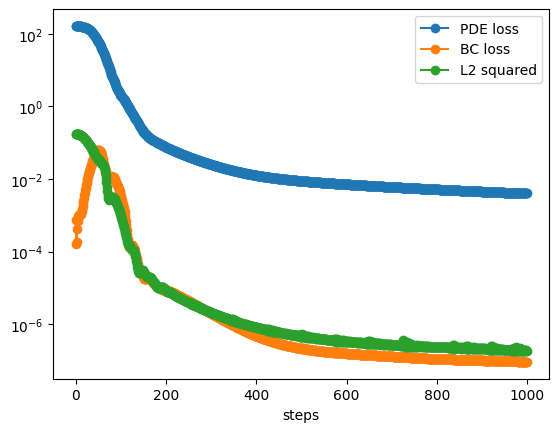

In [2]:
plt.plot(pde_losses, marker='o')
plt.plot(bc_losses, marker='o')
plt.plot(l2_losses, marker='o')
plt.yscale('log')
plt.xlabel('steps')
plt.legend(['PDE loss', 'BC loss', 'L2 squared'])